# 被写体の実面積(表面積)を推定する
*    物体は色のついているものが良い(白以外)
*    物体を撮影するときは光の当たり方などに注意する
*    0.0数ミリ程度の誤差が生じる

In [ ]:
#ライブラリimport
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# ディレクトリ接続(GoogleDriveのマウント)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# グローバルで使う変数

# キャリブレーション用のチェスボード画像
CHESSBOARDIMAGES = glob.glob('/content/drive/MyDrive/CVCameraCalibrateImages/D_ChessPatternImages/*.jpg')

# 面積推定したい物体画像
OBJECTIMAGEAS = glob.glob('/content/drive/MyDrive/CVCameraCalibrateImages/D_SampleImages/*.jpg')

# リサイズしたチェスボード画像
RESIZECBIMAGES = glob.glob('/content/drive/MyDrive/CVCameraCalibrateImages/D_ResizeChessPatternImages/*.jpg')

# リサイズした物体画像
RESIZEOBJECTIMAGES = glob.glob('/content/drive/MyDrive/CVCameraCalibrateImages/D_SampleImages/*jpg')


In [ ]:
# 画素数変換処理(４分の１)
def resizeImage(images):
    # フォルダのjpgを全てリサイズする
    for filename in images:
        
        # 画像読み込み
        img = cv2.imread(filename)

        # 高さを定義する
        height = img.shape[0]

        # 幅を定義
        width = img.shape[1]

        # リサイズ処理(高さと幅の画素数を4分の1にする)
        imgResize = cv2.resize(img, (int(width/4), int(height/4)) )

        # リサイズした画像を指定したパスに保存
        cv2.imwrite('/content/drive/MyDrive/CVCameraCalibrateImages/D_SampleImages/' + 'Q' +  str(os.path.basename(filename)), imgResize)

    print('ImageEcodeComplete')

In [ ]:
# カメラキャリブレーションによって取得する内部パラメータと歪み係数の取得処理

def calibrateCamera(chessimages):

    # チェス盤の盤面数を設定
    CHECKERBOARD = (7,10)

    # //////////////////////////////////////////////////////////////////////////////////////////////////////////////
    # cv2.TERM_CRITERIA_EPS: 指定された精度(epsilon)に到達したら繰り返し計算を終了する
    # cv2.TERM_CRITERIA_MAX_ITER: 指定された繰り返し回数(max_iter)に到達したら繰り返し計算を終了する
    # cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER : 上記のどちらかの条件が満たされた時に繰り返し計算を終了する
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # 各チェックボードから得た3Dベクトルを格納する配列の宣言
    objpoints = []
    
    # 各チェックボードから得た2Dベクトルを格納する配列の宣言
    imgpoints = [] 


    # Defining the world coordinates for 3D points
    objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
    objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    prev_img_shape = None

    for filepath in chessimages:
        img = cv2.imread(filepath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 画像からチェスボードの角を取得する
        # 画像から角がみつかればretにTrueを宣言する
        ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
        
        """
        If desired number of corner are detected,
        we refine the pixel coordinates and display 
        them on the images of checker board
        """
        if ret == True:
            objpoints.append(objp)

            # refining pixel coordinates for given 2d points.
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            
            imgpoints.append(corners2)

            # 角を画像に描写
            img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2,ret)

        
        # 角を描写したチェス画像の表示
        # cv2_imshow(img)

        # img_drawChessboardCornersフォルダにチェスボードのコーナー検出画像を保存
        cv2.imwrite('/content/drive/MyDrive/CVCameraCalibrateImages/D_DrawCorners/' + 'DC' + str(os.path.basename(filepath)), img)

    # 画像の高さと幅を取得
    h,w = img.shape[:2]

    """
    Performing camera calibration by 
    passing the value of known 3D points (objpoints)
    and corresponding pixel coordinates of the 
    detected corners (imgpoints)
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

    print("Camera matrix : \n")
    print(mtx)
    print("dist : \n")
    print(dist)

    # 他の情報、一応コメントアウト
    # print("ret : \n")
    # print(ret)
    # print("rvecs : \n")
    # print(rvecs)
    # print("tvecs : \n")
    # print(tvecs)
    
    # 内部パラメータと歪み係数を返す
    return mtx, dist


In [ ]:
# カメラ内部パラメータを用いて対象物撮影画像の補正
def TranceformingImage(images, mtx, dist):

    # Using the derived camera parameters to undistort the image
    for filepath in images:

        # 画像の取得
        img = cv2.imread(filepath)

        # リサイズした画像の高さ、幅の取得
        h,w = img.shape[:2]

        # Refining the camera matrix using parameters obtained by calibration
        # ROI:Region Of Interest(対象領域)
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

        # Method 1 to undistort the image
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

        # 広角歪み補正をした画像を表示
        # cv2_imshow(dst)

        # 歪み補正した画像をimg_undistortフォルダへ保存
        cv2.imwrite('/content/drive/MyDrive/CVCameraCalibrateImages/D_CalibrationImage/' + 'Calib' + str(os.path.basename(filepath)), dst)

    # 補正した画像を返す
    return dst

In [ ]:
# 補正した画像から

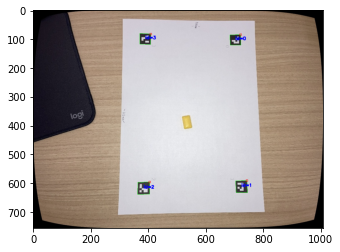

In [ ]:
aruco=cv2.aruco
p_dict=aruco.getPredefinedDictionary(aruco.DICT_4X4_50)#4ブロック×4ブロックを50個使用可能
img = cv2.imread('/content/drive/MyDrive/CVCameraCalibrateImages/D_CalibrationImage/CalibQGUM_MAUE.jpg')
corners, ids, rejectedImgPoints = aruco.detectMarkers(img, p_dict) # 検出
img_marked = aruco.drawDetectedMarkers(img.copy(), corners, ids)   # 検出結果をオーバーレイ
img_marked_rgb=cv2.cvtColor(img_marked,cv2.COLOR_BGR2RGB)
plt.imshow(img_marked_rgb)

In [ ]:
corners2 = [np.empty((1,4,2))]*4#[[[a,a],[b,b],[c,c],[d,d]]]*4 値を初期化しない
corners2

[array([[[  0., 100.],
         [200., 300.],
         [400., 500.],
         [600., 700.]]]), array([[[  0., 100.],
         [200., 300.],
         [400., 500.],
         [600., 700.]]]), array([[[  0., 100.],
         [200., 300.],
         [400., 500.],
         [600., 700.]]]), array([[[  0., 100.],
         [200., 300.],
         [400., 500.],
         [600., 700.]]])]

In [ ]:
corners

[array([[[405., 596.],
         [405., 638.],
         [363., 639.],
         [364., 597.]]], dtype=float32), array([[[743., 591.],
         [745., 633.],
         [706., 633.],
         [704., 592.]]], dtype=float32), array([[[721.,  85.],
         [722., 121.],
         [685., 121.],
         [684.,  86.]]], dtype=float32), array([[[409.,  83.],
         [408., 119.],
         [371., 118.],
         [371.,  81.]]], dtype=float32)]

In [ ]:
ids

array([[2],
       [1],
       [0],
       [3]], dtype=int32)

In [ ]:
ids.ravel()

array([2, 1, 0, 3], dtype=int32)

In [ ]:
for i,c in zip(ids.ravel(), corners):
    corners2[i] = c.copy()

https://plaza.rakuten.co.jp/dobokunoossan/diary/202101240001/

In [ ]:
m = np.empty((4,2))
m

array([[  0., 100.],
       [200., 300.],
       [400., 500.],
       [600., 700.]])

In [ ]:
m[0] = corners2[0][0][2]
m[1] = corners2[1][0][3]
m[2] = corners2[2][0][0]
m[3] = corners2[3][0][1]
marker_coordinates = np.float32(m)#マーカのある四隅の座標を格納
np.float32(m)

array([[685., 121.],
       [704., 592.],
       [405., 596.],
       [408., 119.]], dtype=float32)

In [ ]:
h1=((corners2[0][0][2][0]-corners2[3][0][1][0])**2+(corners2[0][0][2][1]-corners2[3][0][1][1])**2)**0.5
h2=((corners2[2][0][0][0]-corners2[1][0][3][0])**2+(corners2[2][0][0][1]-corners2[1][0][3][1])**2)**0.5
hhh=(h1+h2)/2
print(hhh)

288.01698738917105


In [ ]:
w1=((corners2[0][0][2][0]-corners2[1][0][3][0])**2+(corners2[0][0][2][1]-corners2[1][0][3][1])**2)**0.5
w2=((corners2[2][0][0][0]-corners2[3][0][1][0])**2+(corners2[2][0][0][1]-corners2[3][0][1][1])**2)**0.5
www=(w1+w2)/2
print(www)

474.1962526331629


In [ ]:
# 変形後画像サイズ 縦横比は上記で計算したピクセルを参考にする。
width, height = (int(www),int(hhh))

# 実際に表示する画像の座標を格納
true_coordinates = np.float32([[0,0],[width,0],[width,height],[0,height]])

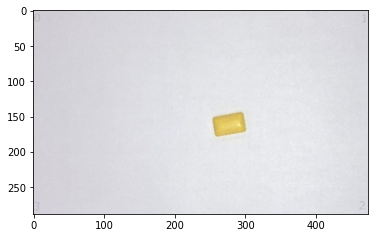

In [ ]:
# 変換率
trans_mat = cv2.getPerspectiveTransform(marker_coordinates,true_coordinates)
# imgを真上から見た画像img_transに変換
img_trans = cv2.warpPerspective(img,trans_mat,(width, height))
img_trans_rgb=cv2.cvtColor(img_trans,cv2.COLOR_BGR2RGB)
plt.imshow(img_trans_rgb)

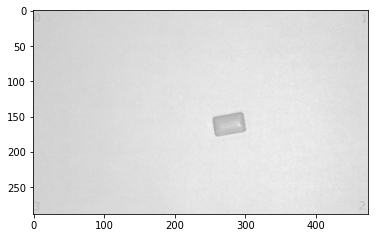

In [ ]:
img_trans_gray=cv2.cvtColor(img_trans,cv2.COLOR_BGR2GRAY)
img_trans_gray_rgb=cv2.cvtColor(img_trans_gray,cv2.COLOR_GRAY2RGB)
plt.imshow(img_trans_gray_rgb)

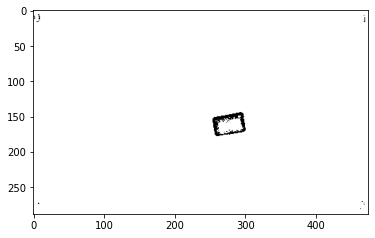

In [ ]:
_,p_binary=cv2.threshold(img_trans_gray,190,255,cv2.THRESH_BINARY)
p_binary_rgb=cv2.cvtColor(p_binary,cv2.COLOR_GRAY2RGB)
plt.imshow(p_binary_rgb)

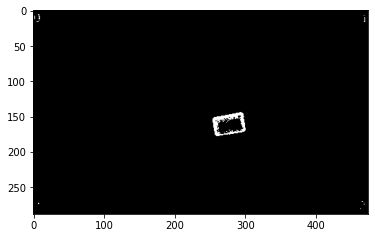

In [ ]:
p_binary=cv2.bitwise_not(p_binary)
plt.imshow(cv2.cvtColor(p_binary,cv2.COLOR_GRAY2RGB))

True

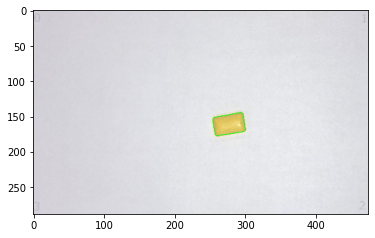

In [ ]:
p_contours,_=cv2.findContours(p_binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
p_and_contours=np.copy(img_trans)
min_p_area=60
large_contours=[cnt for cnt in p_contours if cv2.contourArea(cnt)>min_p_area]
draw_p=cv2.drawContours(p_and_contours,large_contours,-1,(0,255,0))
plt.imshow(cv2.cvtColor(draw_p,cv2.COLOR_BGR2RGB))
cv2.imwrite("draw_p.jpg",draw_p)

In [ ]:
sarea=0
for i, cnts in enumerate(large_contours):
    # 輪郭の面積を計算する。
    area = cv2.contourArea(cnts)
    sarea=sarea+area

In [ ]:
print("総面積={:.2f}cm2".format(sarea * (12.6 * 21.2) / (www * hhh)))

総面積=2.25cm2
